# Task 1: SQL Task

SELECT
   ROUND(SUM(revenue)) 
FROM
   customers 
WHERE
   cc_payments = 1;

SELECT 1.0 * (SELECT COUNT( * ) FROM customers WHERE female_items > 0 AND cc_payments = 1) / (SELECT count( * ) FROM customers WHERE female_items > 0);

SELECT AVG(revenue) FROM customers WHERE android_orders > 0 OR ios_orders > 0 OR desktop_orders > 0;

SELECT customer_id, revenue / items AS mean_item_price FROM customers WHERE male_items > 0 AND revenue > 0 ORDER BY mean_item_price DESC, orders DESC, returns ASC LIMIT 100;

# Task 2: Inferring customer genders

I used the following four approaches:<br>
(1) K-Means++ with all features<br>
(2) K-Means++ with explicit gender-related features<br>
(3) Autoencoder, then K-Means++<br>
(4) Deep Embedded Clustering (DEC)

In [152]:
%autosave 30

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

Autosaving every 30 seconds


In [153]:
df = pd.read_json('data.json')

In [154]:
df.head()

,afterpay_payments,android_orders,apple_payments,average_discount_onoffer,average_discount_used,cancels,cc_payments,coupon_discount_applied,curvy_items,customer_id,...,revenue,sacc_items,shipping_addresses,unisex_items,vouchers,wacc_items,wapp_items,wftw_items,work_orders,wspt_items
0,0,0,0,0.3364,3584.4818,0,1,248.65,0,64f7d7dd7a59bba7168cc9c960a5c60e,...,6946.34,0,4,2,3,1,35,7,0,4
1,0,0,0,0.1404,1404.0966,0,0,0.00,0,fa7c64efd5c037ff2abcce571f9c1712,...,5329.28,0,4,2,0,4,16,2,0,3
2,1,0,0,0.1851,1899.7270,2,1,107.92,0,18923c9361f27583d2320951435e4888,...,14133.87,0,6,2,3,17,96,33,0,3
3,0,0,0,0.0000,3875.6715,0,1,90.90,0,aa21f31def4edbdcead818afcdfc4d32,...,143.64,0,1,2,1,0,1,0,0,0
4,0,0,0,0.0000,0.0000,0,1,0.00,0,668c6aac52ff54d4828ad379cdb38e7d,...,0.00,0,1,0,0,0,0,1,0,0


## Exploratory data analysis

In [155]:
df.dtypes

afterpay_payments             int64
android_orders                int64
apple_payments                int64
average_discount_onoffer    float64
average_discount_used       float64
cancels                       int64
cc_payments                   int64
coupon_discount_applied     float64
curvy_items                   int64
customer_id                  object
days_since_first_order        int64
days_since_last_order         int64
desktop_orders                int64
devices                       int64
different_addresses           int64
female_items                  int64
home_orders                   int64
ios_orders                    int64
is_newsletter_subscriber     object
items                         int64
macc_items                    int64
male_items                    int64
mapp_items                    int64
mftw_items                    int64
msite_orders                  int64
mspt_items                    int64
orders                        int64
other_collection_orders     

In [156]:
df.shape

(46279, 43)

In [157]:
df['customer_id'].nunique()

46030

In [158]:
df[df.duplicated()].shape

(249, 43)

There are 249 duplicated rows. Thus we need to remove them.

In [159]:
df = df.drop_duplicates()
df.shape

(46030, 43)

In [160]:
df['is_newsletter_subscriber'].unique()

array(['N', 'Y'], dtype=object)

The feature 'is_newsletter_subscriber' is of string type and binary values. Thus we need to encode this column.

In [161]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
class_le.fit(df['is_newsletter_subscriber'].values)
print(class_le.classes_)
print(class_le.transform(class_le.classes_))
df['is_newsletter_subscriber'] = class_le.transform(df['is_newsletter_subscriber'].values)
df['is_newsletter_subscriber'].unique()

['N' 'Y']
[0 1]


array([0, 1])

In [162]:
df.isna().sum()

afterpay_payments               0
android_orders                  0
apple_payments                  0
average_discount_onoffer        0
average_discount_used           0
cancels                         0
cc_payments                     0
coupon_discount_applied     10204
curvy_items                     0
customer_id                     0
days_since_first_order          0
days_since_last_order           0
desktop_orders                  0
devices                         0
different_addresses             0
female_items                    0
home_orders                     0
ios_orders                      0
is_newsletter_subscriber        0
items                           0
macc_items                      0
male_items                      0
mapp_items                      0
mftw_items                      0
msite_orders                    0
mspt_items                      0
orders                          0
other_collection_orders         0
other_device_orders             0
parcelpoint_or

There are a large number of NaN values in the column 'coupon_discount_applied'. We can remove this column.

In [163]:
df = df.drop(['coupon_discount_applied'], axis=1)
if 'coupon_discount_applied' not in df.columns: 
    print('\'coupon_discount_applied\' column is removed.')
    print(len(df.columns))

# df['coupon_discount_applied'].fillna(0, inplace=True)
# df['coupon_discount_applied'].isna().sum()

'coupon_discount_applied' column is removed.
42


The following cell plots the distribution of each feature.

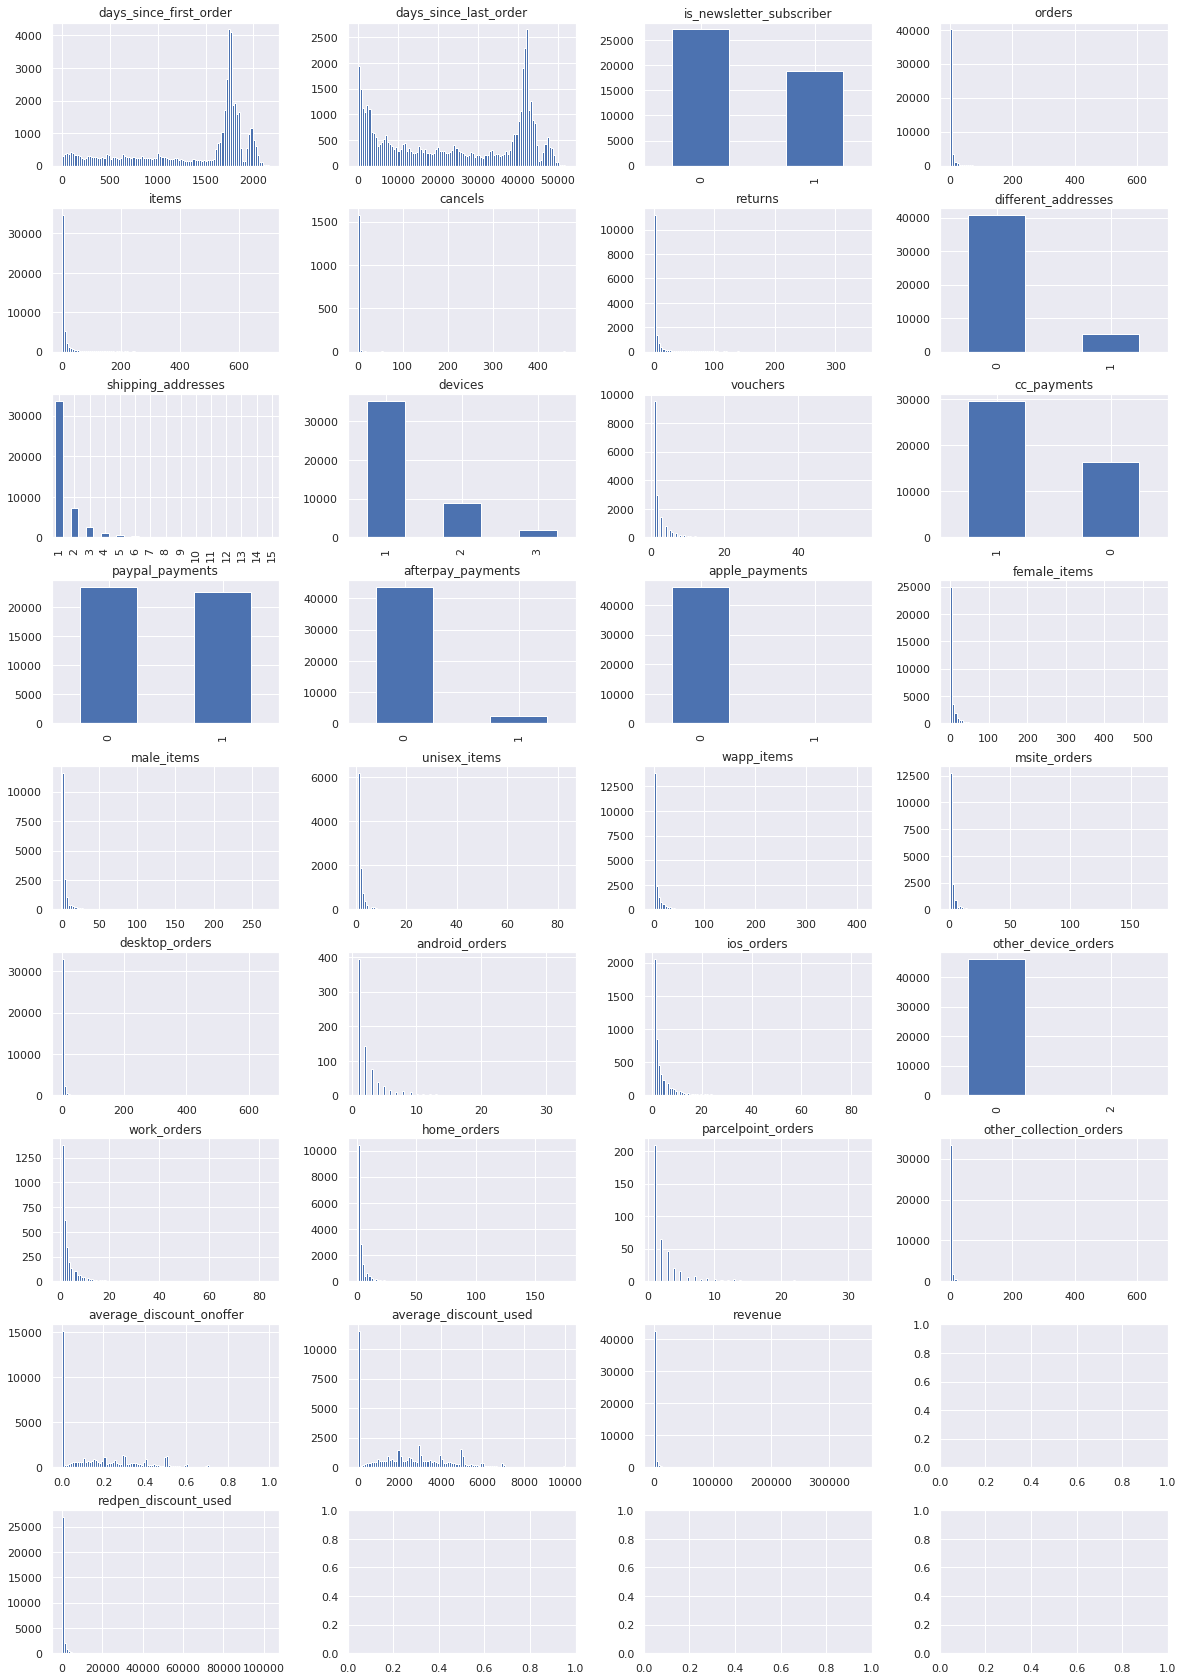

In [164]:
fig, axs = plt.subplots(9, 4, figsize=(20, 30))

df.hist(column='days_since_first_order', ax=axs[0, 0], bins=100);axs[0, 0].set_title('days_since_first_order')
df.hist(column='days_since_last_order', ax=axs[0, 1], bins=100);axs[0, 1].set_title('days_since_last_order')
df['is_newsletter_subscriber'].value_counts().plot(kind='bar', ax=axs[0, 2]);axs[0, 2].set_title('is_newsletter_subscriber')
df[df['orders'] != 0].hist(column='orders', ax=axs[0, 3], bins=100);axs[0, 3].set_title('orders')
# df['orders'].value_counts().plot(kind='bar', ax=axs[0,3]);axs[0,3].set_title('orders')
df[df['items'] != 0].hist(column='items', ax=axs[1, 0], bins=100);axs[1, 0].set_title('items')
df[df['cancels'] != 0].hist(column='cancels', ax=axs[1, 1], bins=100);axs[1, 1].set_title('cancels')
df[df['returns'] != 0].hist(column='returns', ax=axs[1, 2], bins=100);axs[1, 2].set_title('returns')
df['different_addresses'].value_counts().plot(kind='bar', ax=axs[1, 3]);axs[1, 3].set_title('different_addresses')
df['shipping_addresses'].value_counts().plot(kind='bar', ax=axs[2, 0]);axs[2, 0].set_title('shipping_addresses')
df['devices'].value_counts().plot(kind='bar', ax=axs[2, 1]);axs[2, 1].set_title('devices')
# df['vouchers'].value_counts().plot(kind='bar',ax=axs[2,2]);axs[2,2].set_title('vouchers')
df[df['vouchers'] != 0].hist(column='vouchers', ax=axs[2, 2], bins=100);axs[2, 2].set_title('vouchers')
df['cc_payments'].value_counts().plot(kind='bar', ax=axs[2, 3]);axs[2, 3].set_title('cc_payments')
df['paypal_payments'].value_counts().plot(kind='bar', ax=axs[3, 0]);axs[3, 0].set_title('paypal_payments')
df['afterpay_payments'].value_counts().plot(kind='bar', ax=axs[3, 1]);axs[3, 1].set_title('afterpay_payments')
df['apple_payments'].value_counts().plot(kind='bar', ax=axs[3, 2]);axs[3, 2].set_title('apple_payments')
df[df['female_items'] != 0].hist(column='female_items', ax=axs[3, 3], bins=100);axs[3, 3].set_title('female_items')
df[df['male_items'] != 0].hist(column='male_items', ax=axs[4, 0], bins=100);axs[4, 0].set_title('male_items')
df[df['unisex_items'] != 0].hist(column='unisex_items', ax=axs[4, 1], bins=100);axs[4, 1].set_title('unisex_items')
df[df['wapp_items'] != 0].hist(column='wapp_items', ax=axs[4, 2], bins=100);axs[4, 2].set_title('wapp_items');
# Skipping 9 other columns which have similar distributions.....
df[df['msite_orders'] != 0].hist(column='msite_orders', ax=axs[4, 3], bins=100);axs[4, 3].set_title('msite_orders');
df[df['desktop_orders'] != 0].hist(column='desktop_orders', ax=axs[5, 0], bins=100);axs[5, 0].set_title('desktop_orders');
df[df['android_orders'] != 0].hist(column='android_orders', ax=axs[5, 1], bins=100);axs[5, 1].set_title('android_orders');
df[df['ios_orders'] != 0].hist(column='ios_orders', ax=axs[5, 2], bins=100);axs[5, 2].set_title('ios_orders');
df['other_device_orders'].value_counts().plot(kind='bar', ax=axs[5, 3]);axs[5, 3].set_title('other_device_orders');
df[df['work_orders'] != 0].hist(column='work_orders', ax=axs[6, 0], bins=100);axs[6, 0].set_title('work_orders');
df[df['home_orders'] != 0].hist(column='home_orders', ax=axs[6, 1], bins=100);axs[6, 1].set_title('home_orders');
df[df['parcelpoint_orders'] != 0].hist(column='parcelpoint_orders', ax=axs[6, 2], bins=100);axs[6, 2].set_title('parcelpoint_orders');
df[df['other_collection_orders'] != 0].hist(column='other_collection_orders', ax=axs[6, 3], bins=100);axs[6, 3].set_title('other_collection_orders');
df.hist(column='average_discount_onoffer', ax=axs[7, 0], bins=100);axs[7, 0].set_title('average_discount_onoffer');
df.hist(column='average_discount_used', ax=axs[7, 1], bins=100);axs[7, 1].set_title('average_discount_used');
df.hist(column='revenue', ax=axs[7, 2], bins=100);axs[7, 2].set_title('revenue');
# df[df['coupon_discount_applied']!=0].hist(column='coupon_discount_applied', ax=axs[7, 3], bins=100);axs[7, 3].set_title('coupon_discount_applied');
df[df['redpen_discount_used']!=0].hist(column='redpen_discount_used', ax=axs[8, 0], bins=100);axs[8, 0].set_title('redpen_discount_used');
plt.show()

In [165]:
df[df['other_device_orders'] == 2].shape

(1, 42)

'other_device_orders' is not useful therefore this column can be removed.

In [166]:
df = df.drop('other_device_orders', axis=1)
df.shape

(46030, 41)

Now we check the column 'days_since_first_order' and 'days_since_last_order':

In [167]:
df[df['days_since_first_order'] >= df['days_since_last_order']].shape

(2665, 41)

In [168]:
df[df['days_since_first_order'] < df['days_since_last_order']].shape

(43365, 41)

Logically, for a given customer, 'days_since_first_order' should be greater or equal to 'days_since_last_order'. There're 43365 records that doesnot conform with this prior knowledge. I think these two columns are corrupted. Therefore I will swap the two columns conditionally to make it logical and realistic. <br>
On the other hand, the largest values in these two columns are 2000 days (5.5 years) and 50000 days (137 years), which are obviously unreasonable. So I guess the data as such is not recorded with the unit of days. Meanwhile, THE ICONIC was launched in 2011, so the largest possible value for these two columns at most can be 7 years. Therefore a more logical unit for the data may be 'hours'.<br>
In the following I swap the two columns for the corrupted records:

In [169]:
df.loc[df['days_since_first_order'] < df['days_since_last_order'], ['days_since_first_order', 'days_since_last_order']] = \
    df.loc[df['days_since_first_order'] < df['days_since_last_order'], ['days_since_last_order', 'days_since_first_order']].values

df[df['days_since_first_order'] < df['days_since_last_order']].shape

(0, 41)

The following cell plots the correlation coefficients of each pair of columns.

In [170]:
cols_all_features = list(df.columns)
cols_all_features.remove('customer_id')

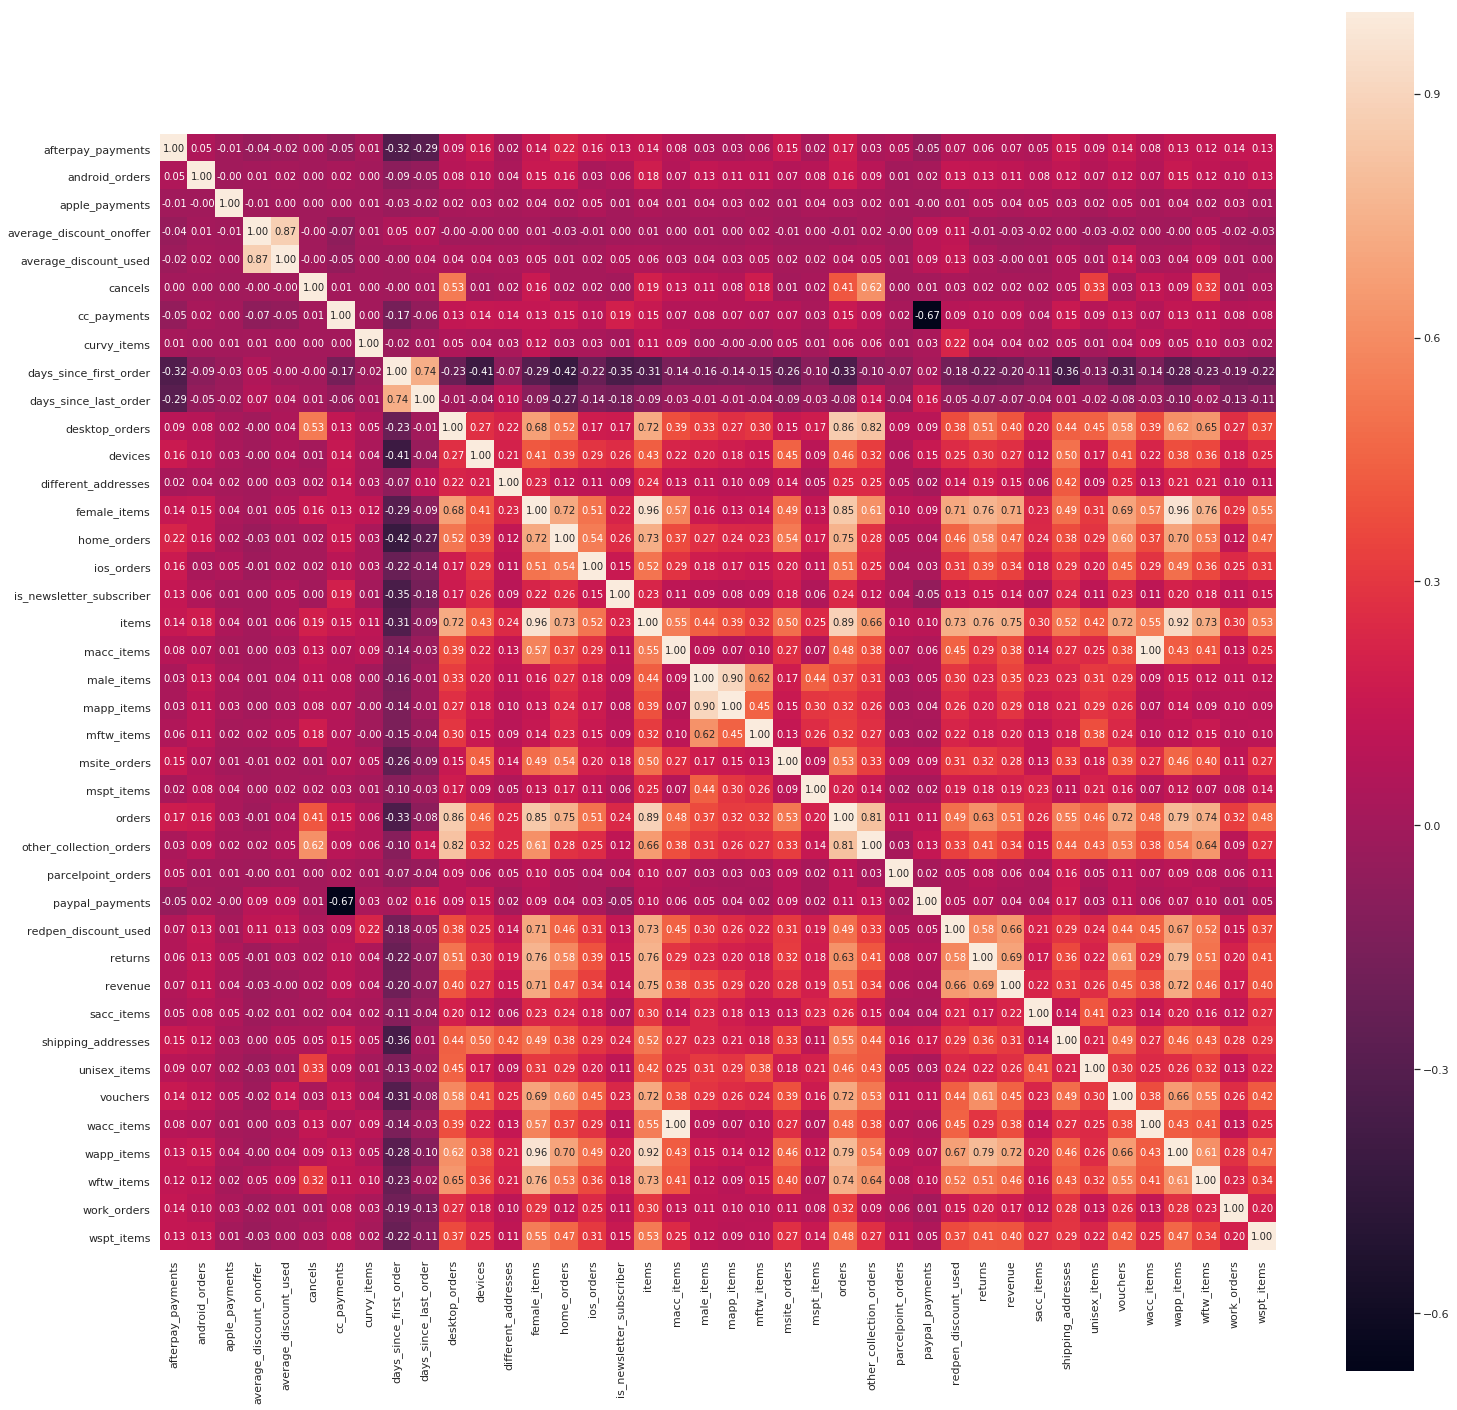

In [171]:
cm = np.corrcoef(df[cols_all_features].values.T)
sns.set(font_scale=1.0)
plt.figure(figsize=(25,25))
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 xticklabels=cols_all_features,
                 yticklabels=cols_all_features)

plt.show()

We can see, 'macc_items' and 'wacc_items' are linearly dependent to each other. Thus we can remove one of the two columns. <p>
The two columns in fact have identical values. This seems to be unreasonable in reality. Considering the objective of the task, it's better to remove both of the two columns.

In [172]:
df = df.drop(['macc_items', 'wacc_items'], axis=1)
cols_all_features.remove('macc_items')
cols_all_features.remove('wacc_items')

# Keep a copy of df without feature scaling
df_orig = df.copy()

df.shape

(46030, 39)

There are active customers who buy more items and less active customers who buy less items. Directly applying clustering algorithms on the original data may leads to clustering w.r.t. different activeness levels, or other patterns  that are not related to genders. <br>
Considering the objective of the task is to distinguish between males and females, we can create the following new features, which mean the percentages of gender-specific items of a certain cateogory. I think this is a set of better features than the original gender-related features for this particular task.

In [173]:
cols_gender_features = ['female_items', 'male_items', 'unisex_items', 'wapp_items', 'mapp_items', 'wftw_items', \
    'mftw_items', 'wspt_items', 'mspt_items', 'curvy_items', 'sacc_items'] # removed 'wacc_items', 'macc_items', 

In [174]:
####!!!
smoothing_value = 0.00001


tmp = df['female_items'] + df['male_items'] + df['unisex_items']
tmp[tmp==0] = smoothing_value
df['female_items'], df['male_items'], df['unisex_items'] = \
    df['female_items'] / tmp, df['male_items'] / tmp, df['unisex_items'] / tmp
del tmp

tmp = df['wapp_items'] + df['mapp_items']
tmp[tmp==0] = smoothing_value
df['wapp_items'], df['mapp_items'] = df['wapp_items'] / tmp, df['mapp_items'] / tmp
del tmp

tmp = df['wftw_items'] + df['mftw_items']
tmp[tmp==0] = smoothing_value
df['wftw_items'], df['mftw_items'] = df['wftw_items'] / tmp, df['mftw_items'] / tmp
del tmp


tmp = df['wspt_items'] + df['mspt_items']
tmp[tmp==0] = smoothing_value
df['wspt_items'], df['mspt_items'] = df['wspt_items'] / tmp, df['mspt_items'] / tmp
del tmp

tmp = df['curvy_items'] + df['sacc_items']
tmp[tmp==0] = smoothing_value
df['curvy_items'], df['sacc_items'] = df['curvy_items'] / tmp, df['sacc_items'] / tmp
del tmp

df[cols_gender_features].head(10)

,female_items,male_items,unisex_items,wapp_items,mapp_items,wftw_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items
0,0.920000,0.040000,0.040000,0.945946,0.054054,1.0,0.0,1.0,0.0,0.0,0.0
1,0.923077,0.000000,0.076923,1.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0
2,0.967105,0.019737,0.013158,0.979592,0.020408,1.0,0.0,1.0,0.0,0.0,0.0
3,0.000000,0.000000,1.000000,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
5,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
7,0.500000,0.000000,0.500000,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.916667,0.000000,0.083333,1.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0


In [175]:
print(df.isna().sum())
df[df.isin([np.inf, -np.inf]).any(1)]

afterpay_payments           0
android_orders              0
apple_payments              0
average_discount_onoffer    0
average_discount_used       0
cancels                     0
cc_payments                 0
curvy_items                 0
customer_id                 0
days_since_first_order      0
days_since_last_order       0
desktop_orders              0
devices                     0
different_addresses         0
female_items                0
home_orders                 0
ios_orders                  0
is_newsletter_subscriber    0
items                       0
male_items                  0
mapp_items                  0
mftw_items                  0
msite_orders                0
mspt_items                  0
orders                      0
other_collection_orders     0
parcelpoint_orders          0
paypal_payments             0
redpen_discount_used        0
returns                     0
revenue                     0
sacc_items                  0
shipping_addresses          0
unisex_ite

,afterpay_payments,android_orders,apple_payments,average_discount_onoffer,average_discount_used,cancels,cc_payments,curvy_items,customer_id,days_since_first_order,...,returns,revenue,sacc_items,shipping_addresses,unisex_items,vouchers,wapp_items,wftw_items,work_orders,wspt_items


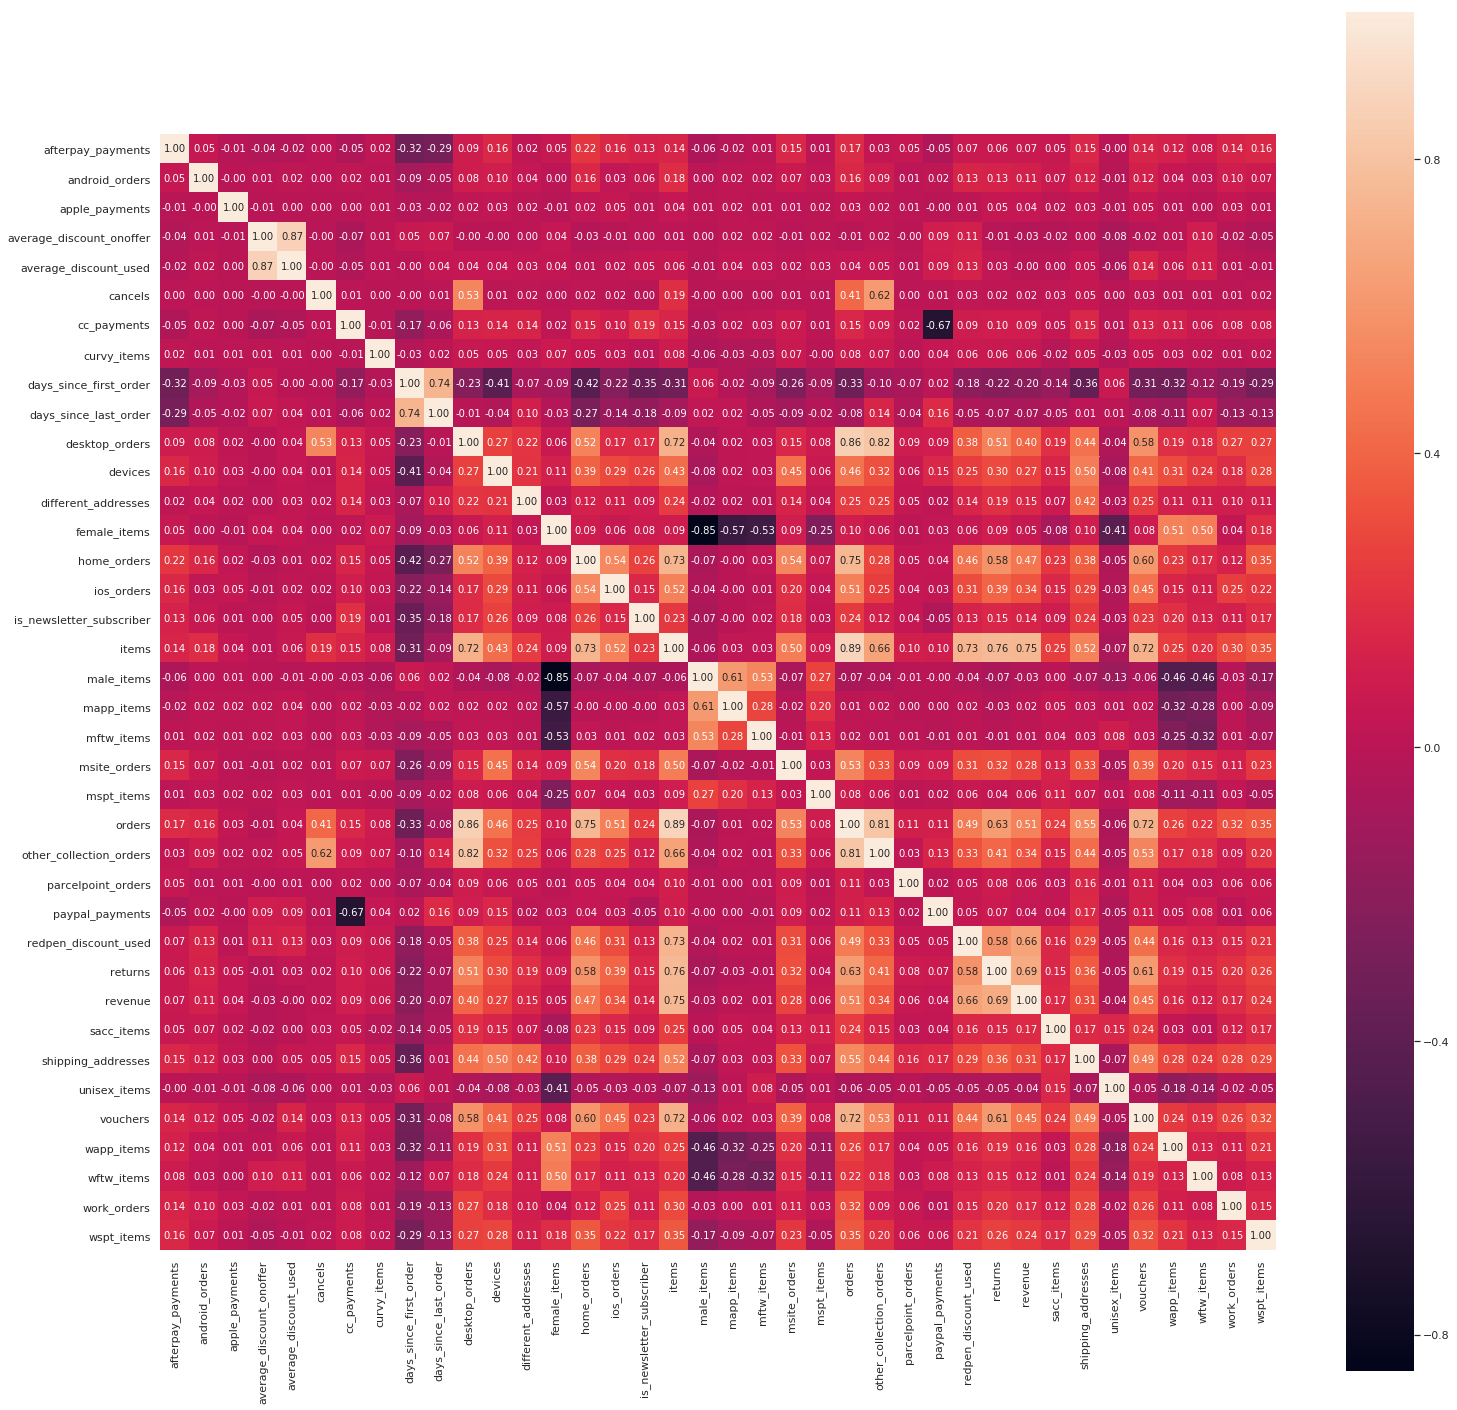

In [176]:
cm = np.corrcoef(df[cols_all_features].values.T)
sns.set(font_scale=1.0)
plt.figure(figsize=(25,25))
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 xticklabels=cols_all_features,
                 yticklabels=cols_all_features)

plt.show()

## Data Preprocessing

Some features are very skewed. We can conduct Box Cox Transformation on these columns.

In [177]:
from scipy import stats

cols_to_transform = \
    [col for col in cols_all_features if col not in cols_gender_features + \
     ['days_since_first_order', 'days_since_last_order', 'is_newsletter_subscriber', \
      'different_addresses', 'shipping_addresses', 'devices', 'cc_payments', 'paypal_payments', \
      'afterpay_payments', 'apple_payments', 'other_device_orders', 'average_discount_onoffer', \
      'average_discount_used']]
for col in cols_to_transform:
    print(col)
    values_t, _ = stats.boxcox(df[col] + 1)
    df.loc[:, col] = values_t
    del values_t


android_orders
cancels
desktop_orders
home_orders
ios_orders
items
msite_orders
orders
other_collection_orders
parcelpoint_orders
redpen_discount_used
returns
revenue
vouchers
work_orders


Now we standardize the features.

In [178]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_all_std = stdsc.fit_transform(df[cols_all_features].values)
print(X_all_std.shape)
df[cols_all_features] = X_all_std
df.head(5)

(46030, 38)


,afterpay_payments,android_orders,apple_payments,average_discount_onoffer,average_discount_used,cancels,cc_payments,curvy_items,customer_id,days_since_first_order,...,returns,revenue,sacc_items,shipping_addresses,unisex_items,vouchers,wapp_items,wftw_items,work_orders,wspt_items
0,-0.237972,-0.129048,-0.023773,0.766800,0.603915,-0.189214,0.745170,-0.117059,64f7d7dd7a59bba7168cc9c960a5c60e,-0.528381,...,1.120531,1.889122,-0.234688,2.273860,-0.179087,1.605144,1.085703,1.163514,-0.272419,2.740996
1,-0.237972,-0.129048,-0.023773,-0.260990,-0.468927,-0.189214,-1.341976,-0.117059,fa7c64efd5c037ff2abcce571f9c1712,-1.334110,...,1.771457,1.729004,-0.234688,2.273860,-0.017242,-0.751393,1.197806,1.163514,-0.272419,2.740996
2,4.202177,-0.129048,-0.023773,-0.026591,-0.225056,5.285025,0.745170,-0.117059,18923c9361f27583d2320951435e4888,-1.334703,...,1.507486,2.326132,-0.234688,4.093723,-0.296743,1.605144,1.155481,1.163514,-0.272419,2.740996
3,-0.237972,-0.129048,-0.023773,-0.997224,0.747193,-0.189214,0.745170,-0.117059,aa21f31def4edbdcead818afcdfc4d32,1.459441,...,-0.673176,-0.302593,-0.234688,-0.455934,4.028876,1.043755,0.160856,-0.903440,-0.272419,-0.374267
4,-0.237972,-0.129048,-0.023773,-0.997224,-1.159802,-0.189214,0.745170,-0.117059,668c6aac52ff54d4828ad379cdb38e7d,1.463709,...,-0.673176,-2.697399,-0.234688,-0.455934,-0.354418,-0.751393,-0.876093,1.163514,-0.272419,-0.374267


## Approach 1: KMeans++, with all features

In [179]:
from sklearn.cluster import KMeans
kmp = KMeans(n_clusters=2,
            init='k-means++',
            n_init=50, 
            max_iter=600,
            tol=1e-04,
            random_state=0,
            n_jobs=6)
y_kmp = kmp.fit_predict(X_all_std)
kmp.inertia_

1493419.3163072274

In [180]:
import collections
collections.Counter(y_kmp)

Counter({1: 13578, 0: 32452})

## Approach 2: KMeans++, with gender-related features only

In [181]:
X_gender_std = df[cols_gender_features].values
print(X_gender_std.shape)

(46030, 11)


In [182]:
kmp_gender = KMeans(n_clusters=2,  # if using 3: male c, f c, c who buy both
                    init='k-means++',
                    n_init=50,
                    max_iter=600,
                    tol=1e-04,
                    random_state=0,
                    n_jobs=6)
y_kmp_gender = kmp_gender.fit_predict(X_gender_std)
kmp_gender.inertia_

368737.59082613816

In [183]:
collections.Counter(y_kmp_gender)

Counter({0: 31726, 1: 14304})

### Exploring the centers of the above two KMeans++ approaches

In [184]:
c11 = np.argmin(np.linalg.norm(X_all_std - kmp.cluster_centers_[0], axis=1))
c12 = np.argmin(np.linalg.norm(X_all_std - kmp.cluster_centers_[1], axis=1))
print('The two centers are:\n'
      '{},{}'.format(c11, c12))

c21 = np.argmin(np.linalg.norm(X_gender_std - kmp_gender.cluster_centers_[0], axis=1))
c22 = np.argmin(np.linalg.norm(X_gender_std - kmp_gender.cluster_centers_[1], axis=1))
print('The two centers are:\n'
      '{},{}'.format(c21, c22))

The two centers are:
34172,17624
The two centers are:
10173,1235


For each of the above two approaches (with different feature spaces), especially the second approach, the two centers seem to be a typical male and a typical female.

In [185]:
print(df_orig[cols_gender_features].iloc[c11, :])
print(df_orig[cols_gender_features].iloc[c12, :])
print()
print(df_orig[cols_gender_features].iloc[c21, :])
print(df_orig[cols_gender_features].iloc[c22, :])

female_items    1
male_items      1
unisex_items    0
wapp_items      0
mapp_items      0
wftw_items      0
mftw_items      0
wspt_items      0
mspt_items      0
curvy_items     0
sacc_items      0
Name: 34290, dtype: int64
female_items    10
male_items       1
unisex_items     0
wapp_items       8
mapp_items       1
wftw_items       1
mftw_items       0
wspt_items       0
mspt_items       0
curvy_items      0
sacc_items       0
Name: 17624, dtype: int64

female_items    28
male_items       3
unisex_items     0
wapp_items       6
mapp_items       1
wftw_items       6
mftw_items       1
wspt_items       0
mspt_items       0
curvy_items      0
sacc_items       0
Name: 10173, dtype: int64
female_items     6
male_items      10
unisex_items     5
wapp_items       6
mapp_items      12
wftw_items       1
mftw_items       1
wspt_items       0
mspt_items       0
curvy_items      0
sacc_items       0
Name: 1235, dtype: int64


### Using the elbow method for the above two KMeans++ approaches

1
2
3
4
5


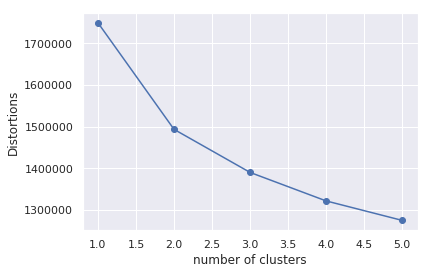

In [186]:
distortions = []
for i in range(1,6):
    print(i)
    kmp = KMeans(n_clusters=i, 
                    init='k-means++',
                    n_init=20,
                    max_iter=300,
                    tol=1e-04,
                    random_state=0,
                    n_jobs=6)
    kmp.fit(X_all_std)
    distortions.append(kmp.inertia_)

plt.plot(range(1,6), distortions, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('Distortions')
plt.show()

1
2
3
4
5


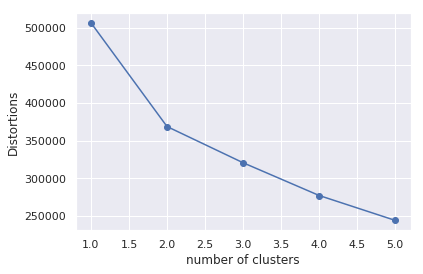

In [187]:
distortions = []
for i in range(1,6):
    print(i)
    kmp_gender = KMeans(n_clusters=i, 
                    init='k-means++',
                    n_init=20,
                    max_iter=300,
                    tol=1e-04,
                    random_state=0,
                    n_jobs=6)
    kmp_gender.fit(X_gender_std)
    distortions.append(kmp_gender.inertia_)

plt.plot(range(1,6), distortions, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('Distortions')
plt.show()

## Training an Autoencoder (approach 3 & 4)
To extract gender-related features and remove information not related to genders

In [188]:
print(X_all_std.shape)

(46030, 38)


AutoEncoder (with gender-related features as the only reconstruction targets)

In [189]:
import tensorflow as tf
import math

# Network parameters
n_input = X_all_std.shape[1] #40
n_hidden = 8 #32 #16 #8 ### n_hidden to be smaller than both n_input and n_output to obtain nontrivial solution
n_output = len(cols_gender_features) # n_input # len(cols_gender_features)
scale_noisy = 0.0 #0.1

epochs = 201 #201
batch_size = 100 #100
display_step = 20

In [190]:
print('{}->{}->{}'.format(n_input, n_hidden, n_output))

38->8->11


In [191]:
# Input and output
X = tf.placeholder('float', [None, n_input], name='X')
y = tf.placeholder('float', [None, n_output], name='y')
dropout_keep_prob = tf.placeholder('float', name='dropout_keep_prob')

In [192]:
# Weights
weights = {
    'encoder_h': tf.Variable(tf.random_normal([n_input, n_hidden], seed=1) * math.sqrt(2/n_input), name='encoder_h'), #seed=1
    'decoder_h': tf.Variable(tf.random_normal([n_hidden, n_output], seed=1) * math.sqrt(2/n_hidden), name='decoder_h')
}
biases = {
    'encoder_b': tf.Variable(tf.random_uniform([n_hidden], 0.0, 0.01, seed=1), name='encoder_b'),
    'decoder_b': tf.Variable(tf.random_uniform([n_output], 0.0, 0.01, seed=1), name='decoder_b')
}

In [193]:
encoder_in = tf.nn.leaky_relu(
    tf.add(
        tf.matmul(X, weights['encoder_h']),
        biases['encoder_b']
    )
)
encoder_in_dropout = tf.nn.dropout(encoder_in, dropout_keep_prob)

decoder_out = tf.nn.leaky_relu(
    tf.add(
        tf.matmul(encoder_in_dropout, weights['decoder_h']),
        biases['decoder_b']
    )
)
y_pred = decoder_out

In [194]:
regularizer = tf.contrib.layers.l2_regularizer(0.0001)
reg_term = tf.contrib.layers.apply_regularization(regularizer, list(weights.values()))

# Cost
cost = tf.reduce_mean(tf.pow(y_pred - y, 2)) + reg_term
# Optimizer
optimizer = tf.train.RMSPropOptimizer(0.01)
optimizer_op = optimizer.minimize(cost)

In [195]:
# Initializer
init = tf.global_variables_initializer()

In [196]:
# Launch the graph in a session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

In [197]:
sess.run(init)

In [198]:
print('Start training autoencoder...')
cols_gender_indexes = [df[cols_all_features].columns.get_loc(cg) for cg in cols_gender_features]
for epoch in range(epochs): # epoch index
    num_batch = int(X_all_std.shape[0] / batch_size) #
    total_cost = 0
    for i in range(num_batch + 1): # batch index
        i_first = batch_size * i + 0
        if i != num_batch:
            i_last = batch_size * i + batch_size - 1
        else:
            i_last = X_all_std.shape[0] - 1

        batch_Xs = X_all_std[i_first:i_last] # original batch data
        batch_Xs_noisy = batch_Xs + scale_noisy * np.random.randn(len(batch_Xs), n_input)
        feeds = {
            X: batch_Xs_noisy,
            y: batch_Xs[:, cols_gender_indexes], #batch_Xs, # batch_Xs[:, cols_gender_indexes],
            dropout_keep_prob: 1.0 #0.9
        }
        _, c_tmp = sess.run([optimizer_op, cost], feed_dict=feeds)
        total_cost += c_tmp
        
    # Display for epoch
    if epoch % display_step == 0:
        print('Epoch {}/{} average cost: {:.6f}'.format(epoch, epochs, total_cost/num_batch))
print('Training ended.')

Start training autoencoder...
Epoch 0/201 average cost: 0.266862
Epoch 20/201 average cost: 0.039295
Epoch 40/201 average cost: 0.039215
Epoch 60/201 average cost: 0.039200
Epoch 80/201 average cost: 0.039247
Epoch 100/201 average cost: 0.039210
Epoch 120/201 average cost: 0.039220
Epoch 140/201 average cost: 0.039222
Epoch 160/201 average cost: 0.039204
Epoch 180/201 average cost: 0.039210
Epoch 200/201 average cost: 0.039222
Training ended.


## Approach 3: Use the trained Autoencoder to encode the input and then conduct KMean++ clustering

In [199]:
#----------------------------------------
## Encode the input data
embeddings_result = sess.run(encoder_in, feed_dict={X: X_all_std})
embeddings_result.shape

(46030, 8)

1
2
3
4
5


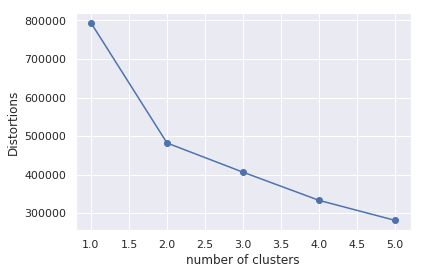

In [200]:
#----------------------------------------
distortions = []
for i in range(1,6):
    print(i)
    kmp = KMeans(n_clusters=i, 
                    init='k-means++',
                    n_init=20,
                    max_iter=300,
                    tol=1e-04,
                    random_state=0,
                    n_jobs=6)
    kmp.fit(embeddings_result)
    distortions.append(kmp.inertia_)

plt.plot(range(1,6), distortions, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('Distortions')
plt.show()

It seems this approach shows a better clustering performance than the previous two.

In [201]:
kmp = KMeans(n_clusters=2,
            init='k-means++',
            n_init=50, 
            max_iter=600,
            tol=1e-04,
            random_state=0,
            n_jobs=6)
y_kmp = kmp.fit_predict(embeddings_result)

collections.Counter(y_kmp)

Counter({1: 31957, 0: 14073})

In [202]:
center_0 = np.argmin(np.linalg.norm(embeddings_result - kmp.cluster_centers_[0], axis=1))
center_1 = np.argmin(np.linalg.norm(embeddings_result - kmp.cluster_centers_[1], axis=1))
print('The two centers are:{},{}'.format(center_0, center_1))

The two centers are:37355,13726


In [203]:
print('The separation between males and females are obvious:')
print(df_orig[cols_gender_features].iloc[center_0, :])
print(df_orig[cols_gender_features].iloc[center_1, :])

The separation between males and females are obvious:
female_items    0
male_items      6
unisex_items    1
wapp_items      0
mapp_items      0
wftw_items      0
mftw_items      0
wspt_items      0
mspt_items      0
curvy_items     0
sacc_items      0
Name: 37506, dtype: int64
female_items    39
male_items       1
unisex_items     1
wapp_items      32
mapp_items       0
wftw_items       5
mftw_items       0
wspt_items       0
mspt_items       0
curvy_items      0
sacc_items       0
Name: 13726, dtype: int64


## Approach 4: Deep Embedded Clustering (DEC)
Xie, Junyuan, Ross Girshick, and Ali Farhadi. "Unsupervised deep embedding for clustering analysis." International conference on machine learning. 2016.

In [204]:
embeddings = encoder_in

with tf.variable_scope("DEC", reuse=tf.AUTO_REUSE):
#     Using the cluster centers of autoencoder+KMeans as the initial centers
    centroids = tf.get_variable(name='centroids', initializer=kmp.cluster_centers_, trainable=True)

    
# 有问题
print(embeddings.shape)
print(centroids.shape)

(?, 8)
(2, 8)


##### Soft assignment probability

In [205]:
q_prob = []
q_dist = []
for j in range(2): # per cluster
    q_dist.insert(
        j,
        tf.pow(1 + tf.reduce_sum(tf.square(embeddings - centroids[j]), axis=1), -1)
    )
for j in range(2): # per cluster
    q_prob.insert(j, q_dist[j] / tf.add_n(q_dist)) #tf.add_n([cluster 0, cluster 1])

del q_dist

##### Target distribution probability

In [206]:
# !!! Use all input data at once

p_prob = []
p_strengthen = []
for j in range(2): # per cluster
    p_strengthen.insert(
        j,
        tf.square(q_prob[j]) / tf.reduce_sum(q_prob[j]) #
    )
for j in range(2): # per cluster
    p_prob.insert(j, p_strengthen[j] / tf.add_n(p_strengthen))
    
del p_strengthen

##### KL Divergence as loss

In [207]:
# regularizer = tf.contrib.layers.l2_regularizer(0.0001)
# reg_term_DEC = tf.contrib.layers.apply_regularization(regularizer, [weights['encoder_h'], centroids])

# #tf.distributions.kl_divergence(p_prob[0], q_prob[0])

loss_kl = 0 #+ reg_term_DEC
for j in range(2):
    loss_kl += tf.reduce_sum(
        p_prob[j] * tf.log(p_prob[j] / q_prob[j])
    )

# Optimizer operation
with tf.variable_scope("DEC", reuse=tf.AUTO_REUSE):
    optimizer_ops_kl = optimizer.minimize(loss_kl)

Initialize new Variables

In [208]:
sess.run(tf.initializers.variables([centroids]))

init_new_variables_op = tf.initializers.variables(
    [optimizer.get_slot(centroids, slot_name) for slot_name in optimizer.get_slot_names()]
)
sess.run(init_new_variables_op)

In [209]:
uninitialized_vars2 = []
for var in tf.global_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars2.append(var)
            
uninitialized_vars2

[]

In [210]:
q_prob_result, p_prob_result = sess.run([q_prob, p_prob], feed_dict={X: X_all_std})
print(q_prob_result[0])
print(p_prob_result[0])
print()
print(q_prob_result[1])
print(p_prob_result[1])

[0.17277138 0.16832335 0.16754003 ... 0.11168956 0.37762135 0.35147533]
[0.07611777 0.07181132 0.07106759 ... 0.02899311 0.4101386  0.35681844]

[0.8272286  0.83167666 0.8324599  ... 0.8883105  0.62237865 0.64852464]
[0.9238822  0.9281887  0.92893237 ... 0.97100693 0.5898614  0.64318156]


In [211]:
print('Start training  DEC...')
epochs_DEC = 4001 #4000
# train all data together, according to the definition of p 
for epoch in range(epochs_DEC): # epoch index
    feeds = {
        X: X_all_std
    }
    _, cost_epoch = sess.run([optimizer_ops_kl, loss_kl], feed_dict=feeds)
        
    # Display for epoch
    if epoch % 200 == 0:
        print('Epoch {}/{} cost: {:.6f}'.format(epoch, epochs_DEC, cost_epoch))
print('Training ended.')

Start training  DEC...
Epoch 0/4001 cost: 2846.628418
Epoch 200/4001 cost: 498.611755
Epoch 400/4001 cost: 327.621155
Epoch 600/4001 cost: 172.256470
Epoch 800/4001 cost: 131.922913
Epoch 1000/4001 cost: 110.556282
Epoch 1200/4001 cost: 96.156258
Epoch 1400/4001 cost: 85.749619
Epoch 1600/4001 cost: 77.816139
Epoch 1800/4001 cost: 71.472809
Epoch 2000/4001 cost: 66.312805
Epoch 2200/4001 cost: 61.920593
Epoch 2400/4001 cost: 58.318935
Epoch 2600/4001 cost: 55.035160
Epoch 2800/4001 cost: 52.290810
Epoch 3000/4001 cost: 49.755493
Epoch 3200/4001 cost: 47.672871
Epoch 3400/4001 cost: 45.662930
Epoch 3600/4001 cost: 43.953918
Epoch 3800/4001 cost: 42.290249
Epoch 4000/4001 cost: 40.838562
Training ended.


In [212]:
q_prob_result, p_prob_result = sess.run([q_prob, p_prob], feed_dict={X: X_all_std})
print(q_prob_result[0])
print(p_prob_result[0])
print()
print(q_prob_result[1])
print(p_prob_result[1])

[0.5000459  0.4998806  0.4999987  ... 0.4884245  0.49349308 0.49619666]
[0.50169444 0.50136393 0.5016     ... 0.47846085 0.48859    0.49399614]

[0.4999541 0.5001193 0.5000013 ... 0.5115755 0.5065069 0.5038033]
[0.49830556 0.49863604 0.4984     ... 0.5215392  0.51140994 0.50600386]


In [213]:
q_prob_result[0][q_prob_result[0]>=0.5] = 1
q_prob_result[0][q_prob_result[0]<0.5] = 0

In [214]:
collections.Counter(q_prob_result[0])

Counter({1.0: 13934, 0.0: 32096})

In [215]:
centroids_result_dec = sess.run(centroids)
print(centroids_result_dec.shape)
centroids_result_dec

(2, 8)


array([[ 1.3150345e+01, -2.2290405e-02,  4.6284852e+00, -1.5737319e-02,
        -5.3208169e-02, -1.5031042e-02, -9.1407048e-03, -3.8075529e-02],
       [-2.3780297e-02,  1.1481235e+00, -1.9804327e-02,  1.1547355e+01,
         1.9808738e-02,  8.6337776e+00,  4.1793213e+00, -2.6791381e-02]],
      dtype=float32)

In [216]:
embeddings_result_dec = sess.run(embeddings, feed_dict={X: X_all_std})

center_0_dec = np.argmin(np.linalg.norm(embeddings_result_dec - centroids_result_dec[0], axis=1))
center_1_dec = np.argmin(np.linalg.norm(embeddings_result_dec - centroids_result_dec[1], axis=1))
print('The two centers are:{},{}'.format(center_0_dec, center_1_dec))
print()
print('The separation between males and females are obvious:')
print(df_orig[cols_gender_features].iloc[center_0_dec, :])
print(df_orig[cols_gender_features].iloc[center_1_dec, :])

The two centers are:41125,20478

The separation between males and females are obvious:
female_items    0
male_items      2
unisex_items    0
wapp_items      0
mapp_items      0
wftw_items      0
mftw_items      0
wspt_items      0
mspt_items      0
curvy_items     0
sacc_items      0
Name: 41317, dtype: int64
female_items    2
male_items      0
unisex_items    0
wapp_items      2
mapp_items      0
wftw_items      0
mftw_items      0
wspt_items      0
mspt_items      0
curvy_items     0
sacc_items      0
Name: 20478, dtype: int64


The output is:

In [218]:
q_prob_result[0]

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [217]:
#----------------------------------------
sess.close()
tf.reset_default_graph()

<b>The other useful features that I can think of are:</b><br>
clicks on male/female items (browsing behaviours)<br>
shopping brands statistics<br>
searching keywords<br>
shopping on the new arrivals<br>
lengths of sessions<br>